In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from helper import get_performance

EPOCHS = 700
BATCH_SIZE = 2048
ACTIVATION = 'swish'
LEARNING_RATE = 0.0007
FOLDS = 5

In [2]:
# Reading the dataset
raw_train = pd.read_csv("dataset/tabular/train.csv")
#raw_train = raw_train.sample(frac=0.01, replace=True, random_state=1)
target = raw_train.target
X_train, X_test, y_train, y_test = train_test_split(raw_train, target, test_size = 0.5, random_state = 29)

X_train = X_train.sample(frac=0.03, replace=True, random_state=1).reset_index(drop=True)
target = X_train.target
X_train = X_train.drop('target', axis = 1)
train = X_train.drop('id', axis = 1)

X_test = X_test.sample(frac=0.03, replace=True, random_state=1).reset_index(drop=True)
y_test = X_test.target
X_test = X_test.drop('target', axis = 1)
test = X_test.drop('id', axis = 1)

print("Train data: ", train.shape)
print("Test data: ", test.shape)

Train data:  (9000, 100)
Test data:  (9000, 100)


In [3]:
X_test = test

In [4]:
target.value_counts()

0    4505
1    4495
Name: target, dtype: int64

In [5]:
y_test.value_counts()

1    4582
0    4418
Name: target, dtype: int64

# Default Model

In [6]:
model_default = svm.SVC()
scores_default = cross_val_score(model_default, X=train, y=target, cv = FOLDS)
model_default.fit(train, target)
y_pred_default = model_default.predict(X_test)
get_performance(X_test, y_test, y_pred_default)

Performance on all data
Precision: 0.525581147833746
Recall: 0.5231111111111111
F1 Score: 0.4855188098273521


(0.525581147833746, 0.5231111111111111, 0.4855188098273521, None)

In [7]:
pd.DataFrame(y_pred_default).value_counts()

1    6928
0    2072
dtype: int64

# SMOTE Oversampling

In [8]:
# SMOTE Oversampling
    # Transform data 
oversample = SMOTE()
X_train_sm, y_train_sm = oversample.fit_resample(train, target)
model_SMOTE = svm.SVC()
scores_SMOTE = cross_val_score(model_SMOTE, X=X_train_sm, y=y_train_sm, cv = FOLDS)
model_SMOTE.fit(X_train_sm, y_train_sm)
y_pred_SMOTE = model_SMOTE.predict(X_test)
get_performance(X_test, y_test, y_pred_SMOTE)

Performance on all data
Precision: 0.5256381741616064
Recall: 0.5231111111111111
F1 Score: 0.4851826217421125


(0.5256381741616064, 0.5231111111111111, 0.4851826217421125, None)

In [9]:
print(X_train_sm.shape,y_train_sm.shape)

(9010, 100) (9010,)


# MAPS

In [10]:
import time 
import sys
sys.path.insert(1, './mmd')
from mmd import diagnoser
from scipy import stats as st
import numpy
#notebook's library
%matplotlib inline
from helper import get_top_f1_rules, get_relevent_attributs_target, get_MMD_results, get_biased_features, get_BGMD_results
from helper import generateTrain_data_Weights

In [11]:
default_result = pd.concat([X_test, y_test], axis=1, join='inner')
default_result.loc[:,"pred"] = y_pred_default

In [12]:
def mispredict_label(row):
    if row['target'] == row['pred']:
        return False
    return True

In [13]:
default_result_copy = default_result.copy()
X_test_copy = X_test.copy()
X_test_copy['mispredict'] = default_result_copy.apply(lambda row: mispredict_label(row), axis=1)

In [14]:
# Get relevent attributes and target 
relevant_attributes, Target = get_relevent_attributs_target(X_test_copy)
# Generate MMD rules and correspodning information
MMD_rules, MMD_time, MMD_Features = get_MMD_results(X_test_copy, relevant_attributes, Target)

#Get biased attributes this time 
biased_attributes = get_biased_features(X_test_copy, relevant_attributes)

BGMD_rules, BGMD_time, BGMD_Features = get_BGMD_results(X_test_copy, biased_attributes, Target)

print('MMD Spent:', MMD_time, 'BGMD Spent:', BGMD_time)
MMD_rules, BGMD_rules

MMD Spent: 336.61958956718445 BGMD Spent: 16.50033736228943


([[0.6170046123052824, 'f43<=4.07133'], [0.5636626705250103, 'f43<=3.07003']],
 [[0.6170046123052824, 'f43<=4.07133'], [0.5636626705250103, 'f43<=3.07003']])

In [15]:
from helper import get_test_data_in_misprediction_areas

final_result = pd.concat([X_test, y_test], axis=1, join='inner')

indexes_in_misprediction_area = get_test_data_in_misprediction_areas(BGMD_rules, X_test)
y_actual_MD = []

for index in indexes_in_misprediction_area:
        y_actual_MD.append(final_result.loc[index]['target'])

In [16]:
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support
grid_upweights = range(1, 101)
best_weight_all = 1
best_f1_all = 0
best_weight_mis = 1
best_f1_mis = 0
f1_all = []
f1_mispredicted = []
acc_all = []
acc_mispredicted = []
recall_all = []
recall_mispredicted = []
for upweight in grid_upweights:
    # give extra weights to training samples in mispredited areas 
    print('Upweight_value: ', upweight)
    weights = generateTrain_data_Weights(BGMD_rules, train, upweight_value=upweight)

    c = Counter(weights)
    print(c.items())

    MAPS_model = svm.SVC()
    scores_MAPS = cross_val_score(MAPS_model, X=train, y=target, cv = FOLDS)
    MAPS_model.fit(train, target, sample_weight = weights)

    y_pred_MAPS = MAPS_model.predict(X_test)

    total_result = get_performance(X_test, y_test, y_pred_MAPS)
    
    acc_all.append(total_result[0])
    recall_all.append(total_result[1])
    f1_all.append(total_result[2])
    
    final_result['y_pred_MAPS'] = y_pred_MAPS
    y_pred_MAPS_MD = []
    for index in indexes_in_misprediction_area:
        y_pred_MAPS_MD.append(final_result.loc[index]['y_pred_MAPS'])
    MAPS_MD_metric = precision_recall_fscore_support(y_actual_MD, y_pred_MAPS_MD, average='weighted')
    acc_mispredicted.append(MAPS_MD_metric[0])
    recall_mispredicted.append(MAPS_MD_metric[1])
    f1_mispredicted.append(MAPS_MD_metric[2])
    
    if total_result[2] > best_f1_all:
        best_f1_all = total_result[2]
        best_weight_all = upweight;
    if MAPS_MD_metric[2] > best_f1_mis:
        best_f1_mis = MAPS_MD_metric[2]
        best_weight_mis = upweight

Upweight_value:  1
dict_items([(1, 9000)])
Performance on all data
Precision: 0.525581147833746
Recall: 0.5231111111111111
F1 Score: 0.4855188098273521
Upweight_value:  2
dict_items([(2, 7263), (1, 1737)])
Performance on all data
Precision: 0.5462642231854484
Recall: 0.5028888888888889
F1 Score: 0.387237365811982
Upweight_value:  3
dict_items([(3, 7263), (1, 1737)])
Performance on all data
Precision: 0.5432549745622637
Recall: 0.5005555555555555
F1 Score: 0.3778992911932992
Upweight_value:  4
dict_items([(4, 7263), (1, 1737)])
Performance on all data
Precision: 0.5505326728863909
Recall: 0.502
F1 Score: 0.3796228040987146
Upweight_value:  5
dict_items([(5, 7263), (1, 1737)])
Performance on all data
Precision: 0.5539117027730294
Recall: 0.5023333333333333
F1 Score: 0.37889935977064876
Upweight_value:  6
dict_items([(6, 7263), (1, 1737)])
Performance on all data
Precision: 0.5615152158479308
Recall: 0.504
F1 Score: 0.38151005003329447
Upweight_value:  7
dict_items([(7, 7263), (1, 1737)])

Performance on all data
Precision: 0.6659535807424689
Recall: 0.6601111111111111
F1 Score: 0.6581616321097505
Upweight_value:  52
dict_items([(52, 7263), (1, 1737)])
Performance on all data
Precision: 0.6669373099825229
Recall: 0.6611111111111111
F1 Score: 0.6591846891534391
Upweight_value:  53
dict_items([(53, 7263), (1, 1737)])
Performance on all data
Precision: 0.6669237944115852
Recall: 0.6612222222222223
F1 Score: 0.6593479135959925
Upweight_value:  54
dict_items([(54, 7263), (1, 1737)])
Performance on all data
Precision: 0.6671235491412911
Recall: 0.6614444444444444
F1 Score: 0.6595827034396983
Upweight_value:  55
dict_items([(55, 7263), (1, 1737)])
Performance on all data
Precision: 0.6681784629744858
Recall: 0.6625555555555556
F1 Score: 0.6607336216259085
Upweight_value:  56
dict_items([(56, 7263), (1, 1737)])
Performance on all data
Precision: 0.6679668368389927
Recall: 0.6624444444444444
F1 Score: 0.6606608464815092
Upweight_value:  57
dict_items([(57, 7263), (1, 1737)])
Perf

Best weight on all is:  100
Best weight on misprediction area is:  95


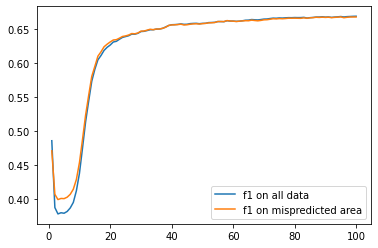

In [17]:
print("Best weight on all is: ", best_weight_all)
print("Best weight on misprediction area is: ", best_weight_mis)
plt.plot(grid_upweights, f1_all, label = "f1 on all data")
plt.plot(grid_upweights, f1_mispredicted, label = "f1 on mispredicted area")
plt.legend()
plt.show()

In [18]:
from helper import get_mispredicted_region_test

weights = generateTrain_data_Weights(BGMD_rules, X_train, upweight_value=best_weight_mis)
c = Counter(weights)
MAPS_model = svm.SVC()
scores_MAPS = cross_val_score(MAPS_model, X=train, y=target, cv = FOLDS)
MAPS_model.fit(train, target, sample_weight = weights)
y_pred_MAPS = MAPS_model.predict(X_test)
get_performance(X_test, y_test, y_pred_MAPS)

default_MD_metric, SMOTE_MD_metric, MAPS_MD_metric = get_mispredicted_region_test(X_test, y_test, y_pred_default, y_pred_SMOTE, y_pred_MAPS, BGMD_rules, ylabel='target')

Performance on all data
Precision: 0.6723298740538259
Recall: 0.669
F1 Score: 0.6681192963462025
y_actual_MD: 7199
y_predict_default_MD: 7199
y_pred_SMOTE_MD: 7199
y_pred_MAPS_MD: 7199

Default: (0.5197027006603138, 0.5075704959022086, 0.47066026409583434, None)
SMOTE: (0.5198302287203719, 0.5075704959022086, 0.47024353687350384, None)
MAPS: (0.67109378340834, 0.6693985275732741, 0.6676221898743718, None)


In [25]:
dict = {'acc_all': acc_all, 'recall_all': recall_all, 'f1_all': f1_all, 'acc_mispredicted': acc_mispredicted, 'recall_mispredicted': recall_mispredicted, 'f1_mispredicted': f1_mispredicted}
out = pd.DataFrame(dict)
out.to_csv('MAPS_Kaggle_Nov_Results.csv')

# Just Train Twice

In [20]:
from helper import generate_JTT_Weights

In [21]:
X_train_1st, X_val, y_train_1st, y_val = train_test_split(train, target, test_size = 0.33, random_state = 29)

model_JTT = svm.SVC()
scores_JTT_1st = cross_val_score(model_JTT, X_train_1st, y=y_train_1st, cv = FOLDS)
model_JTT.fit(X_train_1st, y_train_1st)
y_pred_JTT_val = model_JTT.predict(X_val)
get_performance(X_val, y_val, y_pred_JTT_val)

Performance on all data
Precision: 0.5118644307541532
Recall: 0.5057239057239057
F1 Score: 0.4628626282561791


(0.5118644307541532, 0.5057239057239057, 0.4628626282561791, None)

In [22]:
grid_upweights_JTT = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
best_weight_all_JTT = 1
best_f1_all_JTT = 0
f1_all_JTT = [];

for upweight in grid_upweights_JTT:
    weights = generate_JTT_Weights(y_val.to_list(), y_pred_JTT_val, weight = upweight)
    
    #combine train and validate data
    weights = np.concatenate((np.ones(len(X_train_1st)), weights))
    y_train_2nd = np.concatenate((y_train_1st, y_val))
    X_train_2nd = pd.concat([X_train_1st, X_val])
    X_train_2nd['val_weight'] = weights
    X_train_2nd['target'] = y_train_2nd
    X_train_2nd = X_train_2nd.sample(frac=1, random_state=1).reset_index(drop=True)
    weights = X_train_2nd['val_weight'].to_list()
    y_train_2nd = X_train_2nd['target']
    X_train_2nd = X_train_2nd.drop(['val_weight', 'target'], axis=1)
    
    model_JTT = svm.SVC()
    scores_JTT_2nd = cross_val_score(model_JTT, X_train_2nd, y=y_train_2nd, cv = FOLDS)
    model_JTT.fit(X_train_2nd, y_train_2nd, sample_weight = weights)
    y_pred_JTT = model_JTT.predict(X_test)
    total_result_JTT = get_performance(X_test, y_test, y_pred_JTT)
    f1_all_JTT.append(total_result_JTT[2])
    if total_result_JTT[2] > best_f1_all_JTT:
        best_f1_all_JTT = total_result_JTT[2]
        best_weight_all_JTT = upweight;

Performance on all data
Precision: 0.5223308911614961
Recall: 0.5197777777777778
F1 Score: 0.47172308856409606
Performance on all data
Precision: 0.5226572748241343
Recall: 0.5201111111111111
F1 Score: 0.4732939382691705
Performance on all data
Precision: 0.5214061784347974
Recall: 0.5193333333333333
F1 Score: 0.4728635833196638
Performance on all data
Precision: 0.5212314530616609
Recall: 0.5192222222222223
F1 Score: 0.47278010033670076
Performance on all data
Precision: 0.5201664854300534
Recall: 0.5185555555555555
F1 Score: 0.47243216267292953
Performance on all data
Precision: 0.5191102728720167
Recall: 0.5178888888888888
F1 Score: 0.47208327877840345
Performance on all data
Precision: 0.5185770272991984
Recall: 0.5175555555555555
F1 Score: 0.4719844244931873
Performance on all data
Precision: 0.5188862220706333
Recall: 0.5177777777777778
F1 Score: 0.4724548822748491
Performance on all data
Precision: 0.518364640908167
Recall: 0.5174444444444445
F1 Score: 0.47227917344244136
Perfor

JTT Best weight on all is:  20
JTT Best f1 score on all:  0.4732939382691705


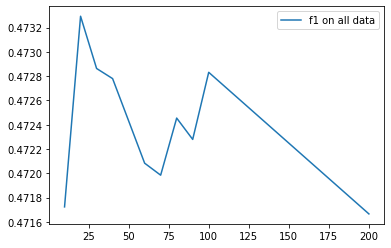

In [23]:
print("JTT Best weight on all is: ", best_weight_all_JTT)
print("JTT Best f1 score on all: ", best_f1_all_JTT)
plt.plot(grid_upweights_JTT, f1_all_JTT, label = "f1 on all data")
plt.legend()
plt.show()

In [24]:
weights = generate_JTT_Weights(y_val.to_list(), y_pred_JTT_val, weight = best_weight_all_JTT)
    
#combine train and validate data
weights = np.concatenate((np.ones(len(X_train_1st)), weights))
y_train_2nd = np.concatenate((y_train_1st, y_val))
X_train_2nd = pd.concat([X_train_1st, X_val])
X_train_2nd['val_weight'] = weights
X_train_2nd['target'] = y_train_2nd
X_train_2nd = X_train_2nd.sample(frac=1, random_state=1).reset_index(drop=True)
weights = X_train_2nd['val_weight'].to_list()
y_train_2nd = X_train_2nd['target']
X_train_2nd = X_train_2nd.drop(['val_weight', 'target'], axis=1)

model_JTT = svm.SVC(kernel='sigmoid', C=0.5)
scores_JTT_2nd = cross_val_score(model_JTT, X_train_2nd, y=y_train_2nd, cv = FOLDS)
model_JTT.fit(X_train_2nd, y_train_2nd, sample_weight = weights)
y_pred_JTT = model_JTT.predict(X_test)
total_result_JTT = get_performance(X_test, y_test, y_pred_JTT)
    

default_MD_metric, SMOTE_MD_metric, MAPS_MD_metric = get_mispredicted_region_test(X_test, y_test, y_pred_JTT, y_pred_SMOTE, y_pred_MAPS, BGMD_rules, ylabel='target')

Performance on all data
Precision: 0.5205071760319352
Recall: 0.5206666666666667
F1 Score: 0.49790821202345037
y_actual_MD: 7199
y_predict_default_MD: 7199
y_pred_SMOTE_MD: 7199
y_pred_MAPS_MD: 7199

Default: (0.516163025951048, 0.5079872204472844, 0.48529384931638553, None)
SMOTE: (0.5198302287203719, 0.5075704959022086, 0.47024353687350384, None)
MAPS: (0.67109378340834, 0.6693985275732741, 0.6676221898743718, None)
